In [11]:
import numpy as np
from tqdm.auto import tqdm
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'serif'

import torch
import torch.nn as nn
from stabnode.utils import set_global_seed
from stabnode.data import TrialsDataset

from data.utils import _load_wrapper

device = "cpu"

seed = 1234
set_global_seed(seed)

In [12]:
gamma = 50
def sigmoid(x,gamma=gamma):
    return 1 / (1+np.exp(-gamma*x))

eps = 0.02
q1, q2 = (0.08, 0.04)
b1 = 1-eps
b2 = 1-eps

def c1_in(x):
    return q1*(1-sigmoid(x-b1))

def c2_in(y):
    return q1*(1-sigmoid(y-b2))

def c1_out(y):
    return q2*(1-sigmoid(y-b2))

def c2_out(y):
    return q2

def two_tank_system(t,x,u):
    x1, x2 = x
    p, v = u
    x1= np.maximum(x1,0)
    x2 = np.maximum(x2,0)
    dx1dt = c1_in(x1)*(1-v)*p-c1_out(x2)*np.sqrt(x1)
    dx2dt = c2_in(x2)*v*p +c1_out(x2)*np.sqrt(x1)-q2*np.sqrt(x2)
    return np.hstack([dx1dt,dx2dt])


In [13]:
p_vals = np.linspace(0,1,101)
v_vals = np.linspace(0,1,101)

p_train = p_vals[10:-10:10]
v_train = v_vals[10:-10:10]

In [14]:
num_x0s = 11
x0s = np.linspace(0,1,num_x0s)

t_max = 100
n_colloc = 301

plotting_rate = 1
cutoff = None

x_trials = [] 
t_trials = []
u_trials = []
for pi in tqdm(p_train[:cutoff:plotting_rate]):
    for vi in v_train[:cutoff:plotting_rate]:
        
        ui_traj = []
        for x0 in zip(x0s, x0s):
            u = np.array([pi,vi])

            sol = solve_ivp(
                two_tank_system,
                t_span = [0,t_max],
                y0 = np.array(x0),
                t_eval= np.linspace(0,t_max, n_colloc),
                args =(u,)
            )

            x_trials.append(sol.y.T)
            t_trials.append(sol.t.reshape(-1,1))
            u_trials.append((pi,vi))

  0%|          | 0/9 [00:00<?, ?it/s]

In [15]:
# conver to torch tensors
batch_size = 11
shuffle = True

x_trials_tensor = [
    torch.tensor(xi,dtype=torch.float32,device=device) for xi in x_trials
]

t_trials_tensor = [
    torch.tensor(ti, dtype=torch.float32,device=device) for ti in t_trials
]

u_trials_tensor = [
    torch.tensor(ui, dtype=torch.float32,device=device) for ui in u_trials
]


dataset = TrialsDataset(x_trials=x_trials_tensor, t_trials=t_trials_tensor, k_trials=u_trials_tensor)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=shuffle)


In [17]:
stop = 0 

for data in dataloader:
    if stop>0:
        break
    Xi,ti, _, ui = data
    stop +=1

In [18]:
x0i = Xi[:,0,:]

In [19]:
Xi.shape,ti.shape,ui.shape

(torch.Size([11, 301, 2]), torch.Size([11, 301, 1]), torch.Size([11, 2]))

## model 

In [20]:
from stabnode.node import StabNODE, FeluSigmoidMLP, GeluSigmoidMLP
from torchode import solve_ivp

In [21]:
f = FeluSigmoidMLP(dims=[2,10,10,2],lower_bound=-1, upper_bound=0)
g = GeluSigmoidMLP(dims=[4,10,10,2],lower_bound=0, upper_bound=1)
model = StabNODE(f,g).to(device)

## model_trainer

In [22]:
import time
import pickle
import copy
import warnings

import numpy as np
import torch 
import torch.nn as nn
from torch.optim import Optimizer
from torchdiffeq import odeint
from torchode import solve_ivp

from stabnode.schedulers import ExpLossTimeDecayScheduler

from pathlib import Path
from typing import Optional, Callable, Tuple
from stabnode.utils import _load_loop_wrapper
from stabnode.node import _create_save_paths, _save_model_opt_cpu, _save_log_history


def model_trainer(
        model: StabNODE,
        opt: torch.optim.Optimizer,
        loss_criteria: Callable,
        train_loader: torch.utils.data.DataLoader,
        n_epochs: int,
        min_improvement:float,
        patience: int,
        solve_method: str='tsit5', 
        save_folder: str|Path=None,
        show_progress:bool=True,
        scheduler: Optional[torch.optim.lr_scheduler._LRScheduler]=None,
        print_every: int=5,
        _precision: int = 4,
        effective_batch_size: int = 1,
        train_dyn = True,
        decay_scheduler: Optional[ExpLossTimeDecayScheduler] = None,
        decay_val:int = 0.0
)-> Tuple[StabNODE,dict]:
    """
    if decay_scheduler is given, this takes priority over decay_val.
    """
    
    loop_wrapper = _load_loop_wrapper(show_progress)
    model_opt_save_path, log_save_path = _create_save_paths(save_folder)

    best_loss = torch.inf
    patience_count = 0
    best_model_epoch = -1
    stopping_criteria = 'max-epochs'

    losses = []
    times = []
    status = []
    patience_hist = []
    lr_hist = []
    alpha_hist = []
    model.train()
    max_iters = len(train_loader)
     #this is training iteration counter to keep track of effective batch size.
    for epoch in loop_wrapper(range(n_epochs)):
        t1 = time.time()
        epoch_loss = 0.0
        num_batches = 0
        epochs_status = []
        iter_counter = 0
        for Xi, Ti, _, ui in train_loader:
            # Xi = Xi.squeeze() # [batch, time, dim]
            # Ti = Ti.squeeze()
            # x0i = x0i.view(-1,1)
            x0i = Xi[:,0,:]



            control = lambda t: ui

            opt.zero_grad()


            if train_dyn == True:
                sol = solve_ivp(
                    f=lambda t, x: model(t, x, control),
                    y0=x0i,
                    t_eval=Ti.squeeze(),
                    method=solve_method
                )
                stat = sol.status
                stat = stat.item() if len(stat) == 1 else list(stat.numpy())
                epochs_status.append(stat)

                if decay_scheduler is not None:
                    decay_val = decay_scheduler.get_alpha() 

                Xi_pred = sol.ys.squeeze()
                loss = loss_criteria(
                    Xi_pred*torch.exp(-decay_val*Ti), 
                    Xi*torch.exp(-decay_val*Ti)
                )

            # Xi = Xi.unsqueeze(-1)
            # cntrl = control(Ti)
            # cntrl = torch.reshape(cntrl,(1,1))
            # cntrl = cntrl.repeat(Xi.shape[0],1)
            # g_id_loss = 100*loss_criteria(model.g(Xi,cntrl),Xi)

            # if train_dyn == True:
            #     #loss = loss +  g_id_loss
            #     loss = loss
            # else:
            #     loss = g_id_loss

            loss.backward()

            iter_counter += 1
            if effective_batch_size>= 1:
                if (iter_counter+1)%effective_batch_size==0 or iter_counter>= max_iters:
                    opt.step()
                    opt.zero_grad()
                    num_batches += 1
            else:
                opt.step()
                opt.zero_grad()
                num_batches += 1

            epoch_loss+= loss.item()
        epoch_loss = epoch_loss / num_batches

        if decay_scheduler is not None:
            decay_scheduler.step(epoch_loss)

            if decay_scheduler.get_alpha() == 0.0 and scheduler is not None:
                scheduler.step(epoch_loss)
                
        elif scheduler is not None:
            scheduler.step(epoch_loss)
     
        cur_lr = opt.param_groups[0]['lr']
        cur_alpha = decay_scheduler.get_alpha() if decay_scheduler is not None else decay_val

        epoch_time = time.time() - t1

        losses.append(epoch_loss)
        times.append(epoch_time)
        status.append(epochs_status)
        lr_hist.append(cur_lr)

        if show_progress:
            if epoch <= 5 or epoch % print_every == 0 or epoch == n_epochs-1:
                print(
                    f"Epoch {epoch}: "
                    f"Loss = {epoch_loss:.{_precision}e}. "
                    f"time = {epoch_time:.{_precision}e}s. "
                    f"lr = {cur_lr:.{_precision}e}. "
                    f"alpha = {cur_alpha:.{_precision}e}"
                )
        # model checks
        if best_loss - epoch_loss >= min_improvement:
            best_loss = epoch_loss
            patience_count = 0
            best_model_epoch = epoch

            if save_folder is not None:
                _save_model_opt_cpu(
                    model,
                    opt,
                    best_model_epoch,
                    best_loss,
                    model_opt_save_path,
                    scheduler
                )

        else:
            patience_count += 1
        
        patience_hist.append(patience_count)

        if patience_count > patience:
            stopping_criteria = 'early-stoppage'
            if show_progress is not None:
                print(f"Patience exceeded: {patience}. Early stoppage executed.")
            break
        
        if save_folder is not None:
            _ = _save_log_history(
                losses,
                times,
                stopping_criteria=f"checkpoint-{epoch}",
                best_model_epoch=best_model_epoch,
                method_status=status,
                patience_hist=patience_hist,
                lr_hist=lr_hist,
                save_path = log_save_path
            )
        
    log_history = _save_log_history(
        losses,
        times,
        stopping_criteria,
        best_model_epoch,
        status,
        patience_hist,
        lr_hist,
        log_save_path,
    )

    return model, log_history

In [23]:
n_epochs = 10
lr = 1e-2
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters()) + list(g.parameters()), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode="min", factor=0.1, patience=10
)
method="tsit5"

model, log = model_trainer(
    model=model,
    opt=opt,
    train_loader=dataloader,
    loss_criteria=loss_criteria,
    n_epochs=n_epochs,
    min_improvement=1e-6,
    patience=100,
    solve_method=method,
    scheduler=scheduler,
    print_every=1,
    _precision = 3
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0: Loss = 6.286e-02. time = 3.031e+01s. lr = 1.000e-02. alpha = 0.000e+00
Epoch 1: Loss = 1.293e-02. time = 2.727e+01s. lr = 1.000e-02. alpha = 0.000e+00
Epoch 2: Loss = 7.114e-03. time = 2.706e+01s. lr = 1.000e-02. alpha = 0.000e+00
Epoch 3: Loss = 5.970e-03. time = 2.709e+01s. lr = 1.000e-02. alpha = 0.000e+00
Epoch 4: Loss = 4.722e-03. time = 2.672e+01s. lr = 1.000e-02. alpha = 0.000e+00
Epoch 5: Loss = 4.146e-03. time = 2.649e+01s. lr = 1.000e-02. alpha = 0.000e+00
Epoch 6: Loss = 4.264e-03. time = 2.752e+01s. lr = 1.000e-02. alpha = 0.000e+00
Epoch 7: Loss = 2.883e-03. time = 2.755e+01s. lr = 1.000e-02. alpha = 0.000e+00
Epoch 8: Loss = 3.158e-03. time = 2.747e+01s. lr = 1.000e-02. alpha = 0.000e+00
Epoch 9: Loss = 2.628e-03. time = 2.739e+01s. lr = 1.000e-02. alpha = 0.000e+00


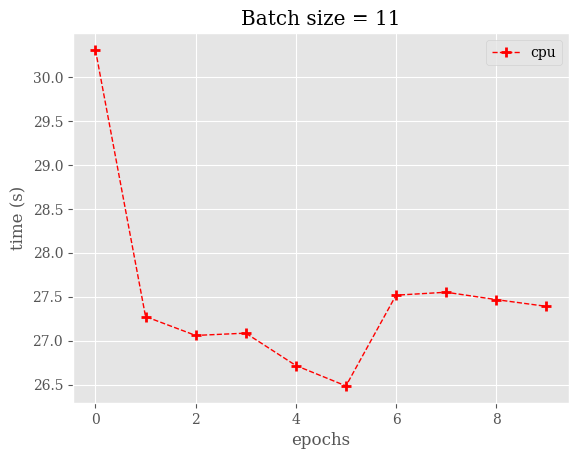

In [77]:
plt.figure(dpi=100)
plt.plot(
    np.arange(len(log['times'])), log['times'],
    linestyle='--', c='red', lw=1,          
    marker='+', markersize=7, markeredgewidth=2,  
    label='cpu'
)
plt.title(f"Batch size = {batch_size}")
plt.xlabel("epochs")
plt.ylabel("time (s)")
plt.legend()
plt.show()

## GPU Training

In [79]:
batch_size = 11
shuffle = True

device_cuda = 'cuda' if torch.cuda.is_available() else 'cpu'
x_trials_tensor_gpu = [
    torch.tensor(xi,dtype=torch.float32,device=device_cuda) for xi in x_trials
]

t_trials_tensor_gpu = [
    torch.tensor(ti, dtype=torch.float32,device=device_cuda) for ti in t_trials
]

u_trials_tensor_gpu = [
    torch.tensor(ui, dtype=torch.float32,device=device_cuda) for ui in u_trials
]


dataset_cuda = TrialsDataset(x_trials=x_trials_tensor, t_trials=t_trials_tensor, k_trials=u_trials_tensor)
dataloader_cuda = torch.utils.data.DataLoader(dataset_cuda,batch_size=batch_size,shuffle=shuffle)

In [ ]:
f = FeluSigmoidMLP(dims=[2,10,10,2],lower_bound=-1, upper_bound=0).to(device_cuda)
g = GeluSigmoidMLP(dims=[4,10,10,2],lower_bound=0, upper_bound=1).to(device_cuda)
model = StabNODE(f,g).to(device_cuda)

In [ ]:
n_epochs = 10
lr = 1e-2
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters()) + list(g.parameters()), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode="min", factor=0.1, patience=10
)
method="tsit5"

model, log = model_trainer(
    model=model,
    opt=opt,
    train_loader=dataloader,
    loss_criteria=loss_criteria,
    n_epochs=n_epochs,
    min_improvement=1e-6,
    patience=100,
    solve_method=method,
    scheduler=scheduler,
    print_every=1,
    _precision = 3
)

In [ ]:
plt.figure(dpi=100)
plt.plot(
    np.arange(len(log['times'])), log['times'],
    linestyle='--', c='red', lw=1,          
    marker='+', markersize=7, markeredgewidth=2,  
    label='cuda'
)
plt.title(f"Batch size = {batch_size}")
plt.xlabel("epochs")
plt.ylabel("time (s)")
plt.legend()
plt.show()